In [1]:
import networkx as nx
import numpy as np
import os
import io
import json
from multiprocessing import Process
import multiprocessing
import matplotlib.pyplot as plt

In [3]:
g = nx.read_graphml("../data/NET-btc-heur_0-week/2012-04-23.graphml")

def degree_dist(G):
    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs:
            degs[deg] = 0
        degs[deg] += 1
        
    return sorted(degs.items())

G_degree_dist = degree_dist(g)
G_x = [k for (k,v) in G_degree_dist]
G_y = [v/len(g.nodes()) for (k,v) in G_degree_dist]



In [7]:
def out_degree_dist(G):
    degs = {}
    for n in G.nodes():
        deg = G.out_degree(n)
        if deg not in degs:
            degs[deg] = 0
        degs[deg] += 1
        
    return sorted(degs.items())


G_out_degree_dist = out_degree_dist(g)
G_x = [k for (k,v) in G_out_degree_dist]
G_y = [v/len(g.nodes()) for (k,v) in G_out_degree_dist]


In [87]:
def degree_dist(G, degree_type=None):
    degs = {}
    for n in G.nodes():
        if degree_type == "in":
            deg = G.in_degree(n)
        elif degree_type == "out":
            deg = G.out_degree(n)
        else:
            deg = G.degree(n)
        
        if deg not in degs:
            degs[deg] = 0
        degs[deg] += 1
    
    G_y = [v/len(G.nodes()) for (k,v) in sorted(degs.items())]    
    G_x = [i for i in range(len(G_y))]
    
    return G_x,G_y


x,G_y = degree_dist(g,"out")

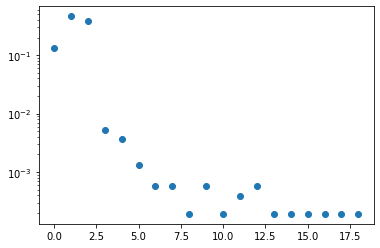

In [88]:
#plt.xscale('log')
plt.yscale('log')
plt.scatter(x, G_y)
    

In [48]:
g.remove_edges_from(list(g.edges()))


OutEdgeView([])

In [10]:
g = nx.read_graphml("../data/NET-btc-heur_0-week/2010-10-18.graphml")
nx.density(g)

import random 


def degree_lst(degree_dict):
    arr = []
    for key,value in degree_dict.items():
        if (value!=0):
            arr.append((key))
    return arr


## permute edges while fixing node degree and direction
def randomize(g):
    
    newg = g.copy()
    ## delete all edges
    newg.clear_edges()
    
    inDeg = dict(g.in_degree())
    outDeg = dict(g.out_degree())
    
    inDeglst = in_degree_lst(inDeg)
    outDeglst = out_degree_lst(outDeg)
    
    while len(inDeglst) > 0:
        
        u = random.choice(outDeglst)
        v = random.choice(inDeglst)
        
        newg.add_edge(u,v)
        
        outDeg[u] -= 1
        inDeg[v] -= 1
        
        inDeglst = degree_lst(inDeg)
        outDeglst = degree_lst(outDeg)
 
    return newg

In [11]:
def bowtie_analysis(G):
    # reverse all direction of the graph
    GT = nx.reverse(G, copy=True)
    # calculate SSC
    scc = list(nx.strongly_connected_components(G))
    if len(scc) == 0:
        return{}

    SSC = max(scc, key=len)

    # take any node n from SSC and do a depth first search
    # through directed graph beginning from node n
    v_any = list(SSC)[0]
    DFS_G = set(nx.dfs_tree(G, v_any).nodes())
    DFS_GT = set(nx.dfs_tree(GT, v_any).nodes())
    OUT = DFS_G - SSC
    IN = DFS_GT - SSC
    V_rest = set(G.nodes()) - SSC - OUT - IN

    TUBES = set()
    INTENDRILS = set()
    OUTTENDRILS = set()
    OTHER = set()

    for v in V_rest:
        # irv => in reaches node v
        irv = len(IN & set(nx.dfs_tree(GT, v).nodes())) is not 0
        # vro => node v reaches out
        vro = len(OUT & set(nx.dfs_tree(G, v).nodes())) is not 0
        if irv and vro:
            TUBES.add(v)
        elif irv and not vro:
            INTENDRILS.add(v)
        elif not irv and vro:
            OUTTENDRILS.add(v)
        elif not irv and not vro:
            OTHER.add(v)

    FRINGE = set()
    DISCONNECTED = set()
    for o in OTHER:
        # orIT => node o reaches INTENDRILS
        orIT = len(INTENDRILS & set(nx.dfs_tree(G, o))) is not 0
        # OTro => OUTTERNDIRLS reaches node o
        OTro = len(OUTTENDRILS & set(nx.dfs_tree(GT, o))) is not 0
        if orIT or OTro:
            FRINGE.add(o)
        else:
            DISCONNECTED.add(o)

    TENDRILS = INTENDRILS.union(OUTTENDRILS)

    def component_result(name, graph_nodes):
        return{name: len(graph_nodes),
               }

    result_dict = dict()
    result_dict.update(component_result("nodes", G.nodes()))
    result_dict.update(component_result("ssc", SSC))
    result_dict.update(component_result("in", IN))
    result_dict.update(component_result("out", OUT))
    result_dict.update(component_result("tubes", TUBES))
    result_dict.update(component_result("tendrils", TENDRILS))
    result_dict.update(component_result("fringe", FRINGE))
    result_dict.update(component_result("disconnected", DISCONNECTED))

    return result_dict


In [16]:
g = nx.read_graphml("../data/NET-btc-heur_0-week/2012-12-31.graphml")

In [ ]:
g_rand = randomize(g)

In [ ]:
print(bowtie_analysis(g))

In [ ]:
print(bowtie_analysis(g_rand))

In [121]:
G = nx.barabasi_albert_graph(50, 3)
seed = 1
G_random = nx.algorithms.swap.double_edge_swap(
        G, 
        nswap=len(G.edges())/2,
        seed=seed, 
        max_tries=100*len(G.edges())
    )
nx.average_clustering(G)

0.26842267433289113

In [78]:
nx.average_clustering(G)

0.22859267443942372

In [6]:
import time
start_time = time.time()


nr_cores = multiprocessing.cpu_count()

core_dict = {}
np_files = np.array(os.listdir("data/NET-btc-heur_0-week"))
directory = "data/NET-btc-heur_0-week"
chunk_lst = np.array_split(np_files, nr_cores)

for i in range(nr_cores):
    process_name = f"p{i}"
    file_name = f"test{i}.json"

    with io.open(os.path.join(file_name), 'w') as db_file:
        db_file.write(json.dumps({}))

    core_dict[process_name] = Process(target = files_walker(list(chunk_lst[i]),file_name, directory))
    
    core_dict[process_name].start()

    #core_dict[process_name].join()

print("--- %s seconds ---" % (time.time() - start_time))

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'data/NET-btc-heur_0-week'